In [105]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

In [106]:
df = pd.read_csv('no_show.csv')

A plotting helper function.

In [133]:
def plotCountNoShow(df, col, horiz=False):
    fig, axes = plt.subplots(1,2, figsize=(14, 6))
    axes = axes.flat
    sns.countplot(df[col], ax=axes[0])
    if horiz:
        sns.barplot(y=col, x='no_show', data=df, ax=axes[1], orient='h')
    else:
        sns.barplot(x=col, y='no_show', data=df, ax=axes[1])
    axes[0].set_title('Counts of {}'.format(col))
    axes[1].set_title('No show rate by {}'.format(col))
    plt.show()

## About the data

The [dataset](https://www.kaggle.com/joniarroba/noshowappointments) describes 111k medical appointments in Brazil, including patient demographic information, geographic and temporal information, and whether the patient showed up. Unfortunately, as of this writing, we don't know the exact source of the data, because the user who uploaded it to kaggle has said its source is confidential. But its an interesting dataset nonetheless, so let's explore it.


In [108]:
len(df)

110527

In [109]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [110]:
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [111]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Normalize columns names.

In [112]:
cols = df.columns
cols = [col.strip().lower().replace('-', '_') for col in cols]
df.columns = cols

Parse patientid into a friendlier format.

In [113]:
df['patientid'] =  df.patientid.apply(lambda x: str(int(x)))

Let's first take a quick look at the no show variable.

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


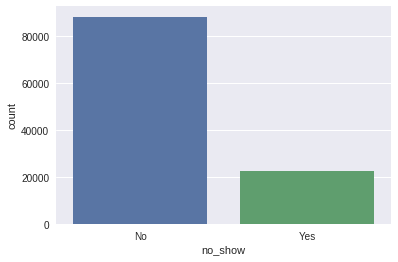

In [114]:
sns.countplot(df.no_show)

In [115]:
df.no_show.value_counts() / len(df)

No     0.798067
Yes    0.201933
Name: no_show, dtype: float64

So for 20% of appointments are no shows. I don't have a background in public health, but that seems large enough to have an impact, both in terms of patient welfare and allocation of medical resources. It would be interesting to compare that number to the no show rate in other countries.

To make our analysis easier, let's encode the no_show variable. 1 will mean the patient didn't show up. 

In [116]:
df['no_show'] = df.no_show.apply(lambda x: 1 if x == 'Yes' else 0)
df.no_show.sum()

22319

### Dates

Let's parse our date columns into component parts and calculate the difference in days between the appointment date and when the appointment was scheduled.

In [117]:
for col in ['scheduledday', 'appointmentday']:
    df[col] = pd.to_datetime(df[col])
    df[col+'_year'] = df[col].dt.year
    df[col+'_month'] = df[col].dt.month
    df[col+'_dow'] = df[col].dt.dayofweek
    
df['scheduledday_hour'] = df.scheduledday.dt.hour
df['date_diff'] = (df.appointmentday.dt.date - df.scheduledday.dt.date).dt.days 

In [118]:
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,...,sms_received,no_show,scheduledday_year,scheduledday_month,scheduledday_dow,appointmentday_year,appointmentday_month,appointmentday_dow,scheduledday_hour,date_diff
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,...,0,0,2016,4,4,2016,4,4,18,0
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,...,0,0,2016,4,4,2016,4,4,16,0
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,...,0,0,2016,4,4,2016,4,4,16,0
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,...,0,0,2016,4,4,2016,4,4,17,0
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,...,0,0,2016,4,4,2016,4,4,16,0


In [119]:
df.appointmentday.min(), df.appointmentday.max()

(Timestamp('2016-04-29 00:00:00'), Timestamp('2016-06-08 00:00:00'))

In [120]:
df.scheduledday.min(), df.scheduledday.max()

(Timestamp('2015-11-10 07:13:56'), Timestamp('2016-06-08 20:07:23'))

As we can see above, our appointment dates span 04/29/2016-06/08/2016, and those appointments began to be scheduled in November of 2015.

#### Days between appointment date and when it was scheduled

In [122]:
df.date_diff.describe()

count    110527.000000
mean         10.183702
std          15.254996
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: date_diff, dtype: float64

In [124]:
df[df.date_diff < 0].date_diff

27033   -1
55226   -1
64175   -1
71533   -6
72362   -1
Name: date_diff, dtype: int64

It looks like we have a few rows where the appointment was apparently schedulded after it was supposed to take place. This  isn't correct, but it's such a small number of rows that we'll leave it for now.

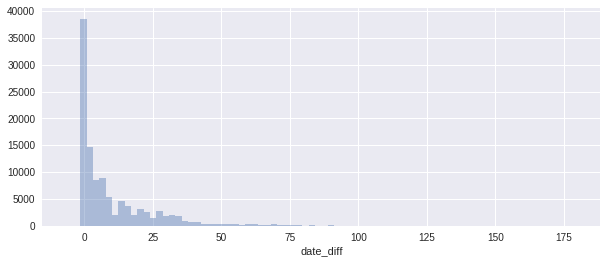

In [125]:
fig, ax = plt.subplots(1,1, figsize=(10, 4))
sns.distplot(df.date_diff, kde=False, ax=ax, bins=80)

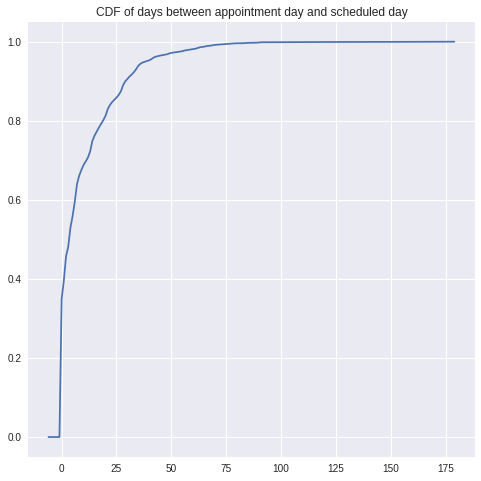

In [126]:
cdfs = df.groupby('date_diff').date_diff.count().cumsum() / len(df)
fig, ax = plt.subplots(1,1, figsize=(8, 8))
ax.plot(cdfs.index.values, cdfs.values)
ax.set_title('CDF of days between appointment day and scheduled day')

In [127]:
cdfs.head(30)

date_diff
-6     0.000009
-1     0.000045
 0     0.348946
 1     0.396111
 2     0.456956
 3     0.481719
 4     0.529581
 5     0.559230
 6     0.595755
 7     0.640142
 8     0.661241
 9     0.675762
 10    0.688348
 11    0.697278
 12    0.707366
 13    0.722584
 14    0.748939
 15    0.762538
 16    0.772951
 17    0.782967
 18    0.792205
 19    0.801650
 20    0.812390
 21    0.829227
 22    0.839840
 23    0.847277
 24    0.852905
 25    0.858668
 26    0.865282
 27    0.874447
Name: date_diff, dtype: float64

We can see that 35% of appointments have been scheduled on the same day and 65% are scheduled less than one week in advance.

Let's now look at the relationship between date_diff and no_show rate.

In [128]:
perc_no_show = df[df.date_diff >= 0].groupby('date_diff').no_show.mean()
perc_no_show.head(30)

date_diff
0     0.046469
1     0.213505
2     0.238216
3     0.235294
4     0.232703
5     0.266097
6     0.247956
7     0.266816
8     0.287307
9     0.274143
10    0.316319
11    0.316109
12    0.316592
13    0.318668
14    0.313423
15    0.333999
16    0.304952
17    0.316170
18    0.305583
19    0.347701
20    0.343724
21    0.308974
22    0.344416
23    0.335766
24    0.377814
25    0.401884
26    0.359781
27    0.315893
28    0.294842
29    0.326905
Name: no_show, dtype: float64

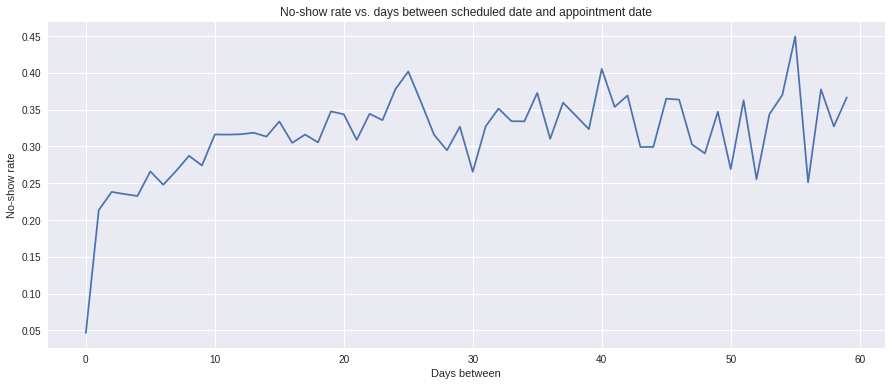

In [129]:
fig, ax = plt.subplots(1,1, figsize=(15, 6))
perc_no_show[:60].plot(ax=ax)
ax.set_title('No-show rate vs. days between scheduled date and appointment date')
ax.set_xlabel('Days between')
ax.set_ylabel('No-show rate')

In the plot above, we've plotted the no-show rate versus the number of days between the scheduling day and appointment day. The rate starts to fluctuate wildly between 60 and 80 days because not many appointments in our data set were scheduled more than that many days in advance. So we have to be skeptical drawing any conclusions regarding anything larger than ~60 days.

We can see that patients are very likely to show up for same-day appointments -- only 4% of those appointments were no-shows. From there, the percentage of no-shows seems to rise until hitting a plateau between 30% and 40%.

#### Day of Week of Appointment

In [130]:
df.groupby('appointmentday_dow').no_show.describe()

,count,mean,std,min,25%,50%,75%,max
appointmentday_dow,,,,,,,,
0,22715.0,0.206471,0.404782,0.0,0.0,0.0,0.0,1.0
1,25640.0,0.200936,0.400708,0.0,0.0,0.0,0.0,1.0
2,25867.0,0.196892,0.397658,0.0,0.0,0.0,0.0,1.0
3,17247.0,0.193541,0.395085,0.0,0.0,0.0,0.0,1.0
4,19019.0,0.212261,0.408920,0.0,0.0,0.0,0.0,1.0
5,39.0,0.230769,0.426833,0.0,0.0,0.0,0.0,1.0


/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


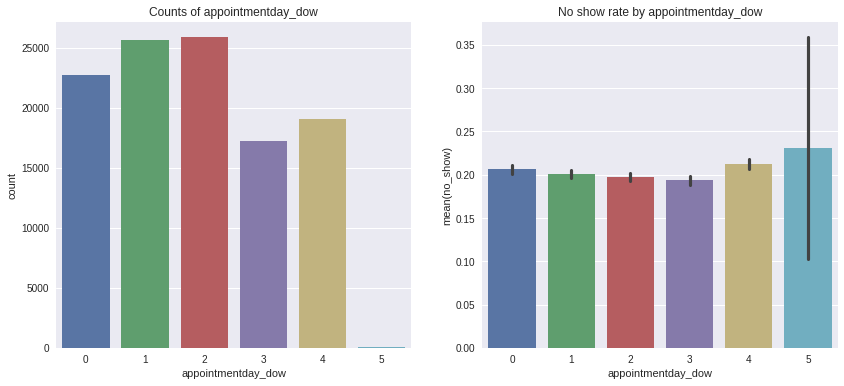

In [134]:
plotCountNoShow(df, 'appointmentday_dow')

We can see that there are no appointments on Sunday and so few on Saturday that we shouldn't try to draw any conclusions about that day. For the rest of the week, the percentage of no shows seems a tad higher on Monday and Friday. The difference is small, but if it's a true effect and not just sampling error, perhaps over thousands and thousands of appointments it could have an impact.

#### Hour Scheduled

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


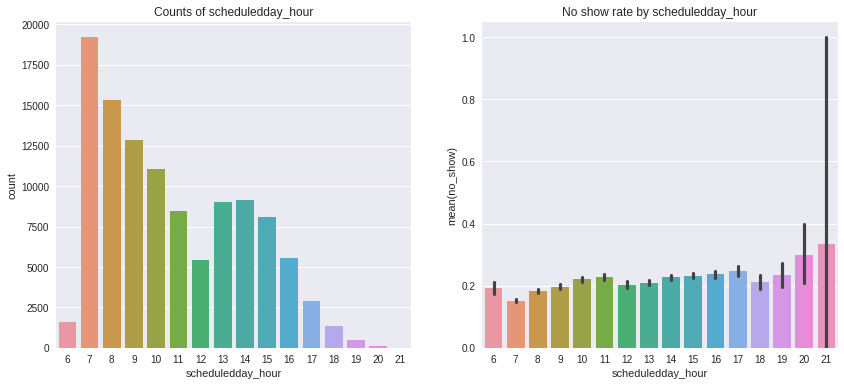

In [135]:
plotCountNoShow(df, 'scheduledday_hour')

Looking at the number of appointments scheduled during each hour of the day, we see that there are too appointments few scheduled after 5pm or before 7am (presumably when the medical office isn't open?) to draw conclusions about those hours.

The plot on the right seems to show that patients are more likely to show up for appointments scheduled right when the office opens (7am or 8am). I'm guessing this is because patients who call to set up appointments early in the morning have something acutely wrong with them that they wanted checked out quickly, which would make them more likely to show up for the appointment. The graph below of the number of days between scheduling an appointment and the appointment date vs. the hour when the appointment was scheduled suggests this could be true.  

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


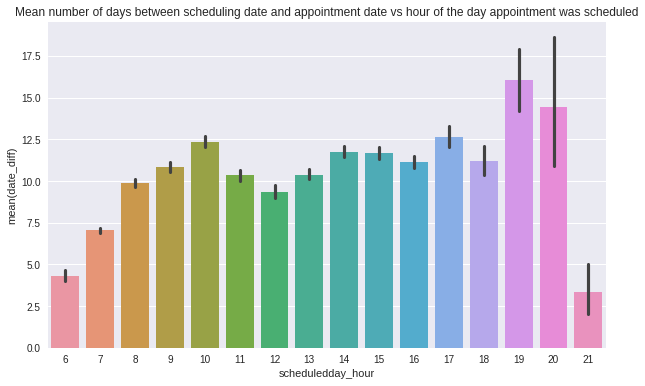

In [136]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.set_title('Mean number of days between scheduling date and appointment date vs hour of the day appointment was scheduled')
sns.barplot(x='scheduledday_hour', y='date_diff', data=df)

#### Month Scheduled

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


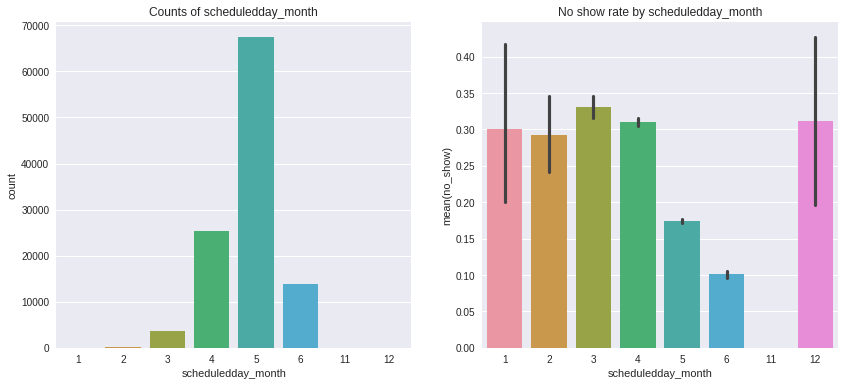

In [137]:
plotCountNoShow(df, 'scheduledday_month')

We can see that the month when the appointment was scheduled seems to be associated with the no show rate. However, as shown below, this is likely not due to anything about the months themselves but rather because the dataset only contains appointments for April-June 2016, If an appointment was scheduled in November or December, it neccesarily has a larger value of date_diff, which we've found to be associated with no_show rate. 

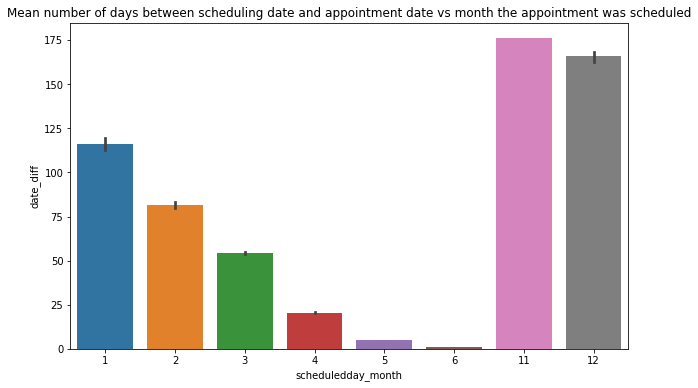

In [321]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.set_title('Mean number of days between scheduling date and appointment date vs month the appointment was scheduled')
sns.barplot(x='scheduledday_month', y='date_diff', data=df)

### Patient Characteristics

#### Number of previous no shows of patient

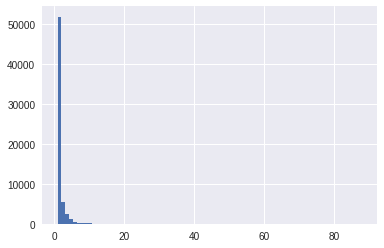

In [139]:
df.groupby('patientid').size().hist(bins=80)

In [140]:
(df.groupby('patientid').size() > 1).sum() / len(df)

0.22057053932523274

Only 22% of patients have more than one appointment in the database.

We'll create a new variable -- the previous number of times a patients has been a no show.

First, we'll sort the df by appointment date.

In [25]:
df = df.sort_values('appointmentday')

In [26]:
print(df.appointmentday.head()) 
df.appointmentday.tail()

0       2016-04-29T00:00:00Z
2151    2016-04-29T00:00:00Z
2152    2016-04-29T00:00:00Z
2153    2016-04-29T00:00:00Z
2154    2016-04-29T00:00:00Z
Name: appointmentday, dtype: object


92055    2016-06-08T00:00:00Z
99217    2016-06-08T00:00:00Z
99218    2016-06-08T00:00:00Z
99224    2016-06-08T00:00:00Z
91900    2016-06-08T00:00:00Z
Name: appointmentday, dtype: object

Now we group by patient and get the cummulative sum of no shows. Note that this takes a while.

In [ ]:
df2 = df.copy()
i=0
for pid in df.patientid.unique():
    i+=1
    df2.loc[df2.patientid == pid, 'prev_no_show'] = df2.loc[df2.patientid == pid, 'no_show'].cumsum()

Because np.cumsum includes the value of the current row in the cummulative sum, we need to adjust our value down by one to offset that.

In [336]:
def adjPrevNoShow(x):
    return x.prev_no_s - 1 if x.no_show == 1 else x.prev_no_s

df2['prev_no_s'] = df2.apply(adjPrevNoShow, axis=1)

len(df)

110527

Let's check if we did that right.

In [167]:
def checkPrevNoShow(pid):
    return df2[df2.patientid == pid][['appointmentday', 'no_show', 'prev_no_show']]

In [181]:
checkPrevNoShow('38962632722')

,appointmentday,no_show,prev_no_show
2188,2016-04-29 00:00:00,1,0.0
2187,2016-04-29 00:00:00,1,1.0
76622,2016-05-02 00:00:00,0,2.0
104099,2016-06-01 00:00:00,0,2.0
91128,2016-06-03 00:00:00,1,2.0


In [182]:
checkPrevNoShow('11474894783')

,appointmentday,no_show,prev_no_show
31300,2016-05-11 00:00:00,1,0.0
31297,2016-05-11 00:00:00,1,1.0
101596,2016-06-03 00:00:00,1,2.0


In [183]:
checkPrevNoShow('18961433933')

,appointmentday,no_show,prev_no_show
55894,2016-05-02 00:00:00,1,0.0
55742,2016-05-09 00:00:00,1,1.0
24333,2016-05-12 00:00:00,0,2.0
29082,2016-05-12 00:00:00,0,2.0
24654,2016-05-16 00:00:00,0,2.0
59657,2016-05-20 00:00:00,0,2.0
24692,2016-05-24 00:00:00,0,2.0
55717,2016-05-30 00:00:00,1,2.0
99093,2016-06-01 00:00:00,0,3.0
103820,2016-06-02 00:00:00,0,3.0


Looks good. That took a long time, so let's save the result.

In [172]:
df2.to_csv('no_show_prev_adj_2.csv', encoding='utf-8', index=True)

From the plot below, we see that an appointment is more likely to be a no show if the patient has not shown up for an appointment previously. However, in the vast majority of the appointments, the patient has no previous no shows, so this feature may not be that helpul.

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


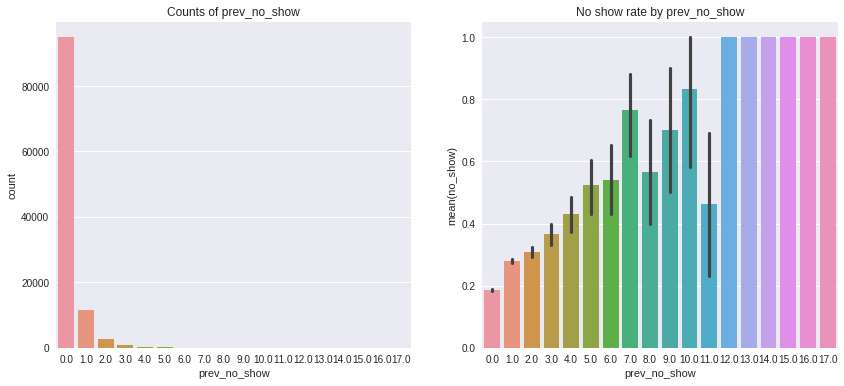

In [179]:
plotCountNoShow(df2, 'prev_no_show')

#### Gender

We see a lot more appointments for women than men, but gender doesn't seem to make much of a difference on no shows.

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


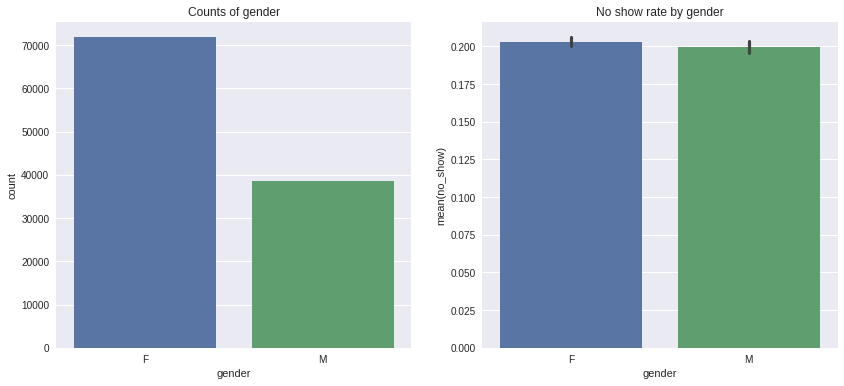

In [185]:
plotCountNoShow(df2, 'gender')

#### Handicap

The handicap column has 5 different levels. We aren't told what each level means, but a safe assumption may mean that 0 indicates no handicap. It's hard to draw too many conclusions, because there are so few cases for some of the levels of the variable.

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


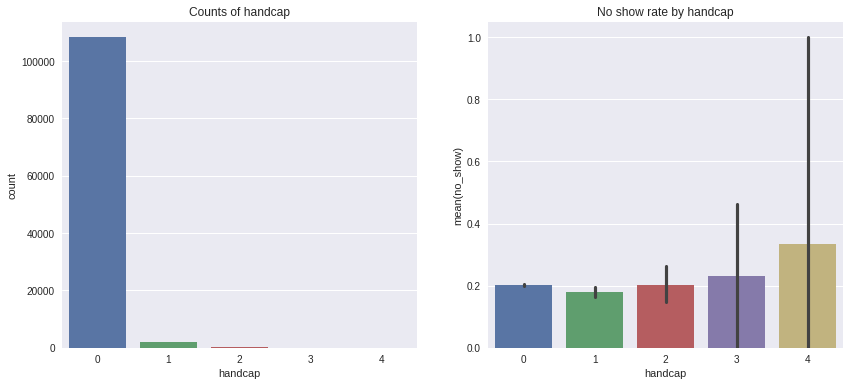

In [186]:
plotCountNoShow(df2, 'handcap')

#### Age

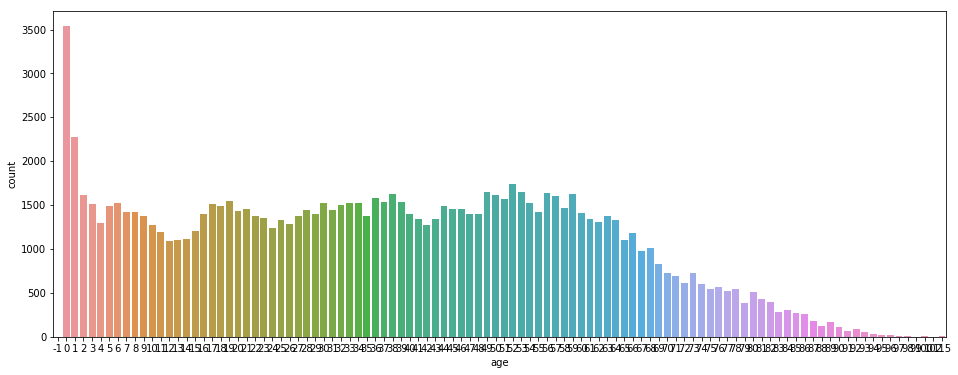

In [45]:
fig, ax = plt.subplots(1,1, figsize=(16, 6))
sns.countplot(df.age, ax=ax)

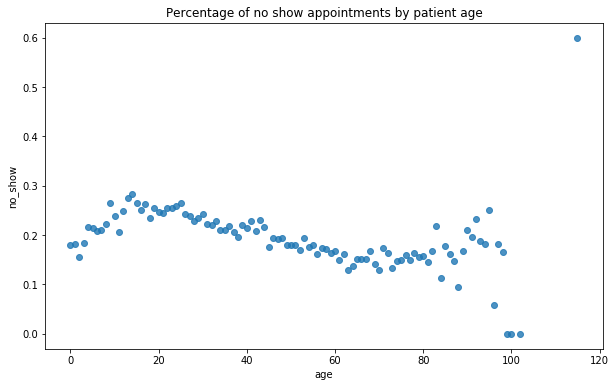

In [46]:
perc_no_show_age = df[df.age >=0].groupby('age').no_show.mean().reset_index()
fig, ax = plt.subplots(1,1, figsize=(10, 6))
sns.regplot(x='age', y='no_show',data=perc_no_show_age, ax=ax, fit_reg=False)
ax.set_title('Percentage of no show appointments by patient age')

Above, we see an interesting relationship between the age of the patient and the percentage of appointments resulting in a no show. The no show percentage starts low and rises to peak in the teenage years before falling again. The percentage begins to rise again around age 70, but we need to be careful interpreting that, as there are few appointments for patients above 70.

#### Medical Conditions

There are a handful of features that seem to correspond to certain medical conditions, including hypertension, diabetes and alcoholism. We don't have specific guidance as to what these columns mean, but it's reasonable to assume that either the patient has been previously diagnosed with this condition or that the appointment has been set up to check on or treat the condition.

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


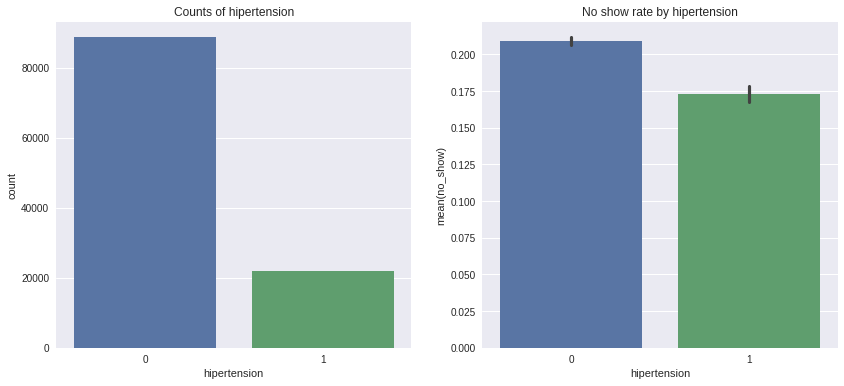

In [188]:
plotCountNoShow(df2, 'hipertension')

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


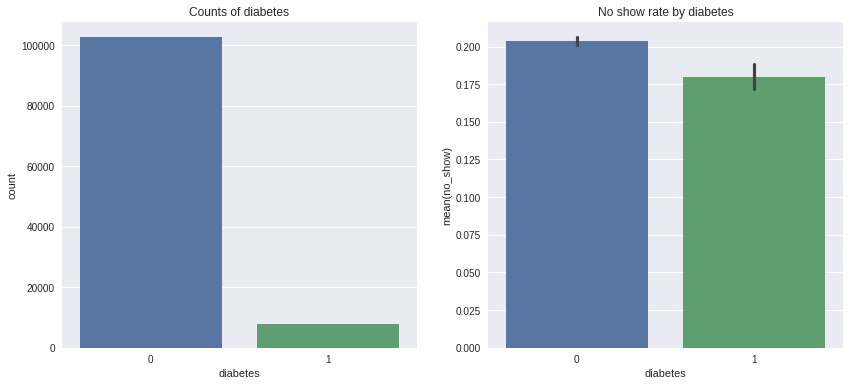

In [189]:
plotCountNoShow(df2, 'diabetes')

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


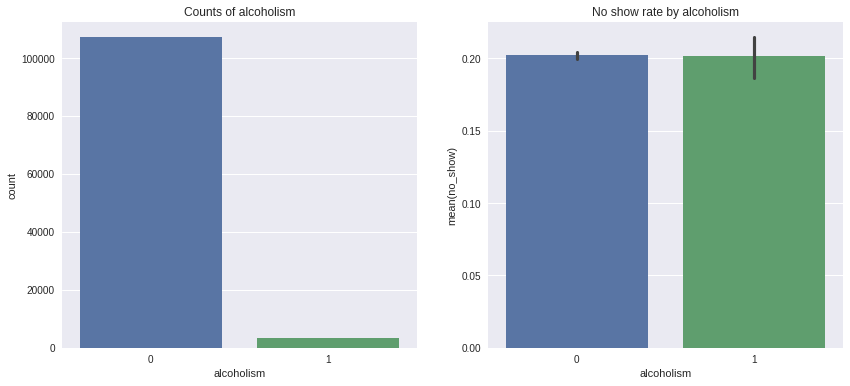

In [190]:
plotCountNoShow(df2, 'alcoholism')

It seems that presence of hypertension and diabetes makes appointments slightly less likely to result in a no show. Alcoholism doesn't seem to have an effect, though fewer alcoholism samples means we're less certain.

### SMS received

The description of the says that a 1 in the sms_received column indicates that '1 or more messages were sent to the patient'. I assume this means reminder messages prior to the appointment, but it's unclear. As you can see below, sending messages to the patient seems to be associated with an increased likelihood of a no show. 

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


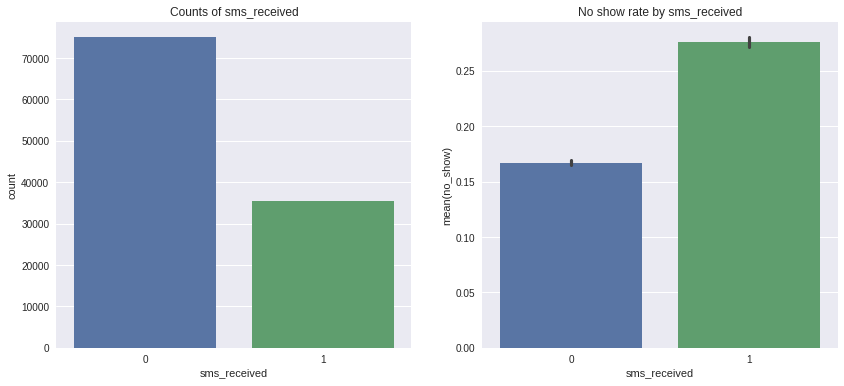

In [191]:
plotCountNoShow(df2, 'sms_received')

However, when we remove same day appointments (right plot below), we that a sent message decreases the no show rate slightly. The effect is due to the fact that no messages were sent for same day appointments and patients we much more likely to show up for those appointments.

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


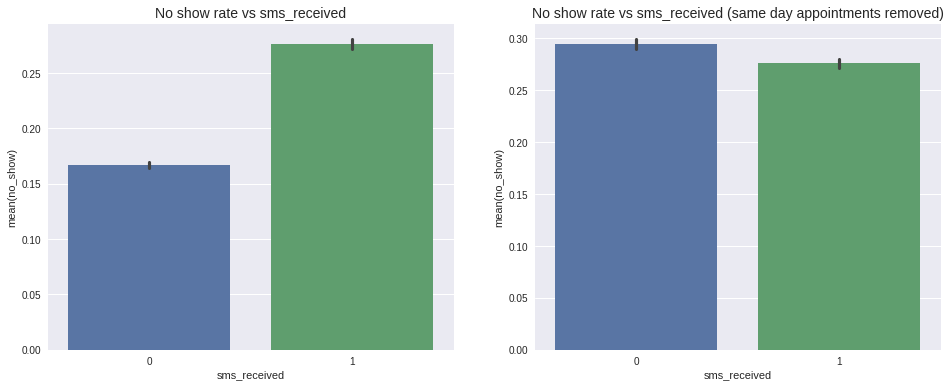

In [192]:
fig, axes = plt.subplots(1,2,figsize=(16, 6))
_ = axes = axes.flat
sns.barplot(x='sms_received', y='no_show', data=df, ax=axes[0])
axes[0].set_title('No show rate vs sms_received', fontsize=14)
sns.barplot(x='sms_received', y='no_show', data= df[df.date_diff > 0], ax=axes[1])
_= axes[1].set_title('No show rate vs sms_received (same day appointments removed)', fontsize=14)
plt.savefig('rate_vs_message.png')

### Neighborhood

The neighborhood column tells us the location of the appointment. I haven't checked all 81 unique neighborhoods in the data set, but the most prevalent seem lie in or around Vitoria, the capital of the state of Espirito de Santo The most frequent ones seem to lie in  the state coastal region of the state of Espírito Santo.

Because there are so many neighbourhoods, let's limit our exploration to those with over 1000 appointments.

In [193]:
neighborhood_counts = df.neighbourhood.value_counts()
neighborhood_counts = neighborhood_counts[neighborhood_counts > 1000]

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


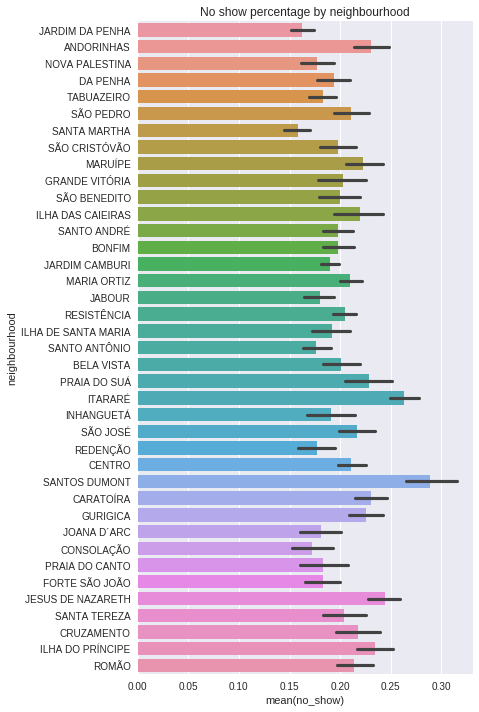

In [194]:
fig, ax = plt.subplots(1,1, figsize=(6, 12))
sns.barplot(y='neighbourhood', x='no_show', data=df[df.neighbourhood.isin(neighborhood_counts.index)], ax=ax)
ax.set_title('No show percentage by neighbourhood')

Above, we that it locations in some neighborhood seem to have a higher rate of no shows that others. For example, Santa Martha has a relatively low no sho rate while Sanots Dumont has a high rate. A deep dive into why that might be is beyond the scope of this notebook.

### Scholarship/Observation

The publisher of the dataset writes that 'scholarship means [bolsa familia](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia)', a Brazilian welfare program centered around cash transfers. I assume a one that column indicate that the patient recieves benefits from the program, but I'm not certain. As you can see below, you can see that a one is associated with a higher rate of no shows, though it's not a huge difference.



/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


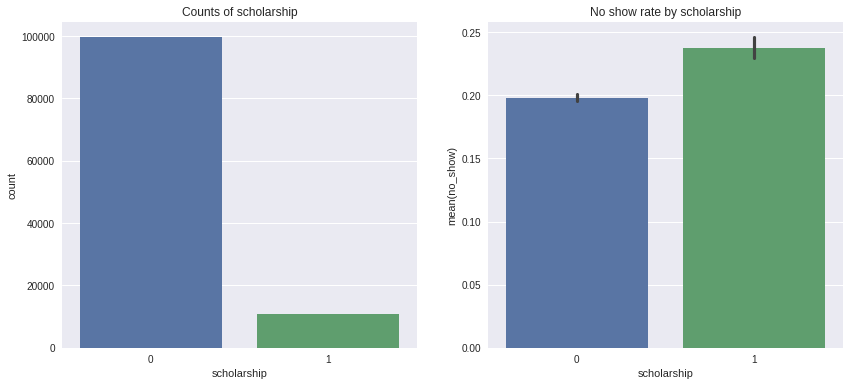

In [195]:
plotCountNoShow(df2, 'scholarship')